The aim of this notebook is to show some samples of augmentation on bbox level as opposed to entire image. The idea was taken from the paper [Learning Data Augmentation Strategies for Object Detection](https://arxiv.org/pdf/1906.11172.pdf). 

A short note about the paper:

1. The paper aimed to learn the data augmentation policy from a COCO training set and verify if the similar policies can be transferred to other data sets for increasing mAP score for object detection.
2. They used validation set accuracy to seach for novel object detection augmentation policy.
3. Examples of these policy:

    1. (Color, 0.2, 8), (Rotate, 0.8, 10)
    2. (BBox Only ShearY, 0.8, 5)
    3. (SolarizeAdd, 0.6, 8), (Brightness, 0.8, 10)
    4. (ShearY, 0.6, 10), (BBox Only Equalize,0.6, 8)
    5. (Equalize, 0.6, 10), (TranslateX, 0.2, 2)


4. (Rotate, 0.8, 10): 

    1. Rotate: Name of the transformation
    2. 0.8: probability with which to apply transformation
    3. 10: Magnitute of the transformation.
    
    
5. The complete list of transformation applied were classified into 3 categories:

    1. **Color operations:** Distort color channels like Equalize, Contrast etc.
    2. **Geomertic Operation:** Rotate, Shear etc.
    3. **Bounding Box Operations:** BBox_Only_Equalize, BBox_only_Rotate etc.

6. The result of applying these policies is as follows:
    1. The bbox only operation provides an increase of 0.4 mAP.
        From the Paper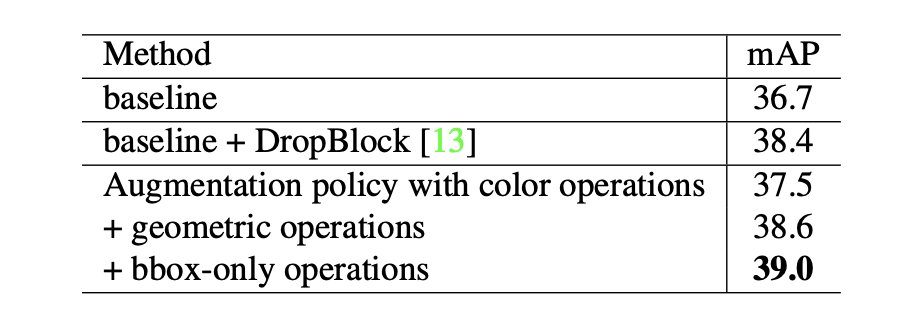




7. **In the paper the authors have used following BBox_only operation:**

    1. policy(name='Translate_Y_BBox', probability=0.6, magnitude=6)
    
    2. policy(name='Shear_X_BBox', probability=0.8, magnitude=4)
    
    3. policy(name='Shear_Y_BBox', probability=0.8, magnitude=2)
    
    4. policy(name='Fliplr_BBox', probability=0.0, magnitude=10)
    
    5. policy(name='Cutout_BBox', probability=0.4, magnitude=6)


Example of transformation on data from the author:

From the Paper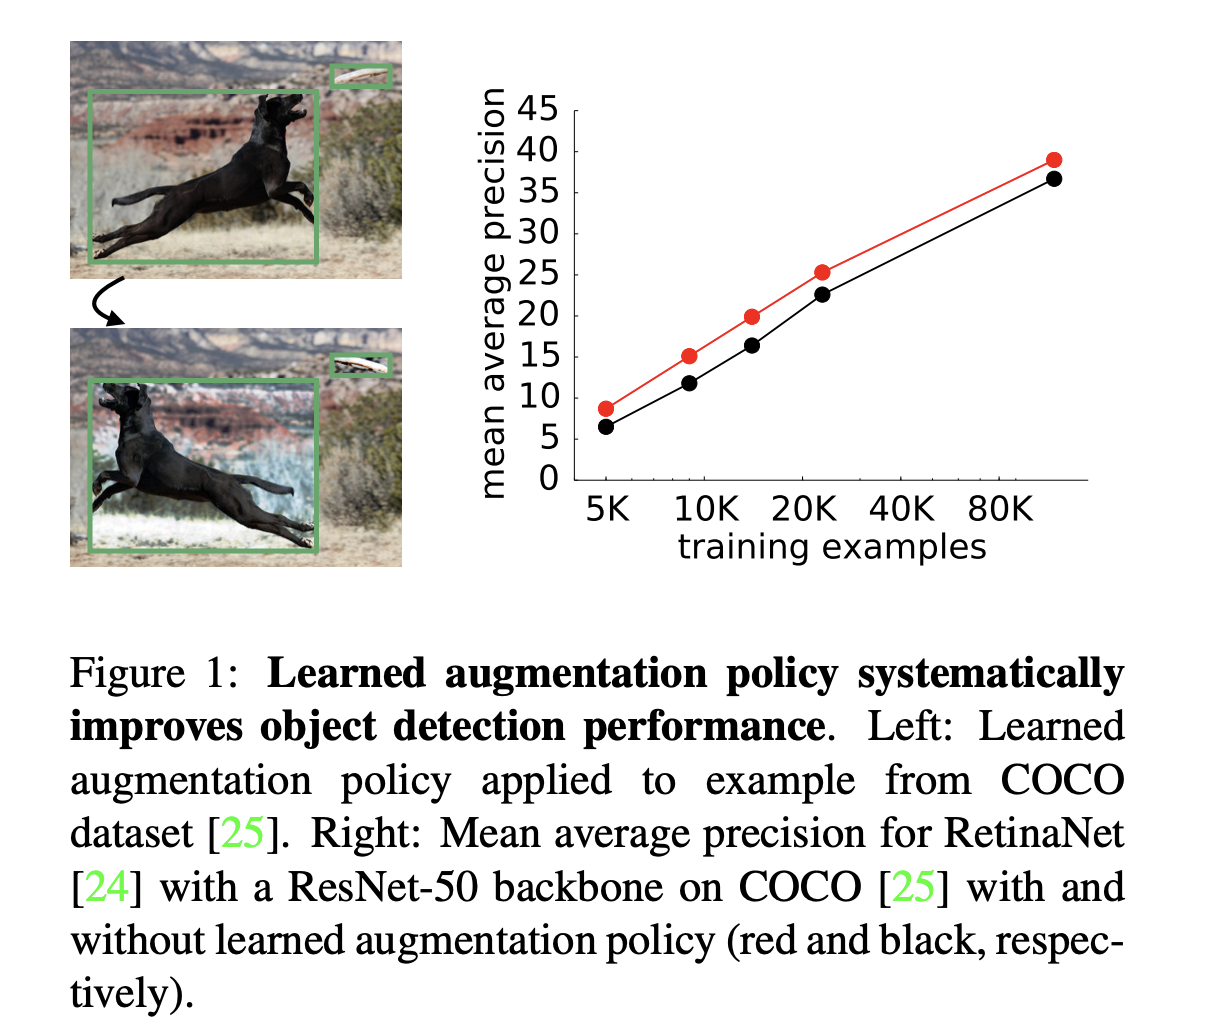



I have added few other transformation as below, will soon add the operations by the author also.

In [ ]:
import pandas as pd
from tqdm import tqdm
import albumentations as A
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Reading Dicom Images Correctly

In [ ]:
# https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

# Reading the csv File

In [ ]:
## adding the center of each bbox
df = pd.read_csv('../input/vinbigdata-chest-xray-abnormalities-detection/train.csv')
df['x_center'] = (df['x_min'] + df['x_max'])/2
df['y_center'] = (df['y_min'] + df['y_max'])/2

In [ ]:
def drawBBoxOnImage(img, bboxes):
    for i, box in enumerate(bboxes):
        cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), [0,0,0], 3)
    return img

In [ ]:
bbox = df[df.image_id=='0108949daa13dc94634a7d650a05c0bb'].iloc[0][['x_min','y_min', 'x_max', 'y_max']]

In [ ]:
bboxes = [list(bbox)]

# Get Sample Image And BBox


In [ ]:
def getOrigImage():
    img = read_xray('../input/vinbigdata-chest-xray-abnormalities-detection/train/0108949daa13dc94634a7d650a05c0bb.dicom')
    bbox = df[df.image_id=='0108949daa13dc94634a7d650a05c0bb'].iloc[0][['x_min','y_min', 'x_max', 'y_max']].astype(int)
    img = cv2.imwrite('./test_img.jpg', img)
    img = cv2.imread('./test_img.jpg')
    return img, bbox

# Plotting BBox Augmented Samples

In [ ]:
def plotBBoxLevelAug(imgs, subTitles, cols = 4, size = 7, scale=4, cmap='gray'):
    rows = 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img is not None:
            img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
        plt.title(subTitles[i])
    plt.show()

In [ ]:
configDict = {'CoarseDropout' : {"p":1, "max_holes":30},
'Blur' : {'p': 1},
'Clahe' : {'p':1},
'ColorJitter' : {'brightness':0.4, 'contrast':0.4, 'saturation':0.4, 'hue':0.4, 'p':1},
'Cutout' : {'p':1},
'Equalize' : {'p':1},
}


# BBox Level Augmentations

In [ ]:
bboxAugmentations = {
    'CoarseDropout': lambda dic: A.CoarseDropout(**dic)(image=img[bbox['y_min']:bbox['y_max'], bbox['x_min']:bbox['x_max']])['image'],
    'Blur': lambda dic: A.Blur(**dic)(image=img[bbox['y_min']:bbox['y_max'], bbox['x_min']:bbox['x_max']])['image'],
    'ColorJitter': lambda dic: A.ColorJitter(**dic)(image=img[bbox['y_min']:bbox['y_max'], bbox['x_min']:bbox['x_max']])['image'],
    'Clahe': lambda dic: A.CLAHE(**dic)(image=img[bbox['y_min']:bbox['y_max'], bbox['x_min']:bbox['x_max']])['image'],
    'Cutout': lambda dic: A.Cutout(**dic)(image=img[bbox['y_min']:bbox['y_max'], bbox['x_min']:bbox['x_max']])['image'],
    'Equalize': lambda dic: A.Equalize(**dic)(image=img[bbox['y_min']:bbox['y_max'], bbox['x_min']:bbox['x_max']])['image']
}


    

In [ ]:
def applyAugOnBBox(img, bbox, augType):
    imgCopyWithAug = img.copy()
    bbox = bbox.astype(int)
    bboxImg = img[bbox['y_min']:bbox['y_max'], bbox['x_min']:bbox['x_max']]
    augmentedBBox = bboxAugmentations[augType](configDict[augType])
    imgCopyWithAug[bbox['y_min']:bbox['y_max'], bbox['x_min']:bbox['x_max']] = augmentedBBox
    plotBBoxLevelAug([img, bboxImg, augmentedBBox, imgCopyWithAug], ['Original Image', 'bboxImage','augmented bbox', 'bbox augmentaion merged with image'])
    

In [ ]:
img, bbox = getOrigImage()

**CLAHE:** Contrast Limited Adaptive Histogram Equalization to the input image

In [ ]:
applyAugOnBBox(img, bbox, 'Clahe')

**CoarseDropout**: Dropping rectangular regions in the image and filling them with 0.

In [ ]:
applyAugOnBBox(img, bbox, 'CoarseDropout')

Blur the input image using a random-sized kernel.

In [ ]:
applyAugOnBBox(img, bbox, 'Blur')

Randomly changes the brightness, contrast, and saturation of an image.

In [ ]:
applyAugOnBBox(img, bbox, 'ColorJitter')

CoarseDropout of the square regions in the image.

In [ ]:
applyAugOnBBox(img, bbox, 'Cutout')

Equalize the image histogram.

In [ ]:
applyAugOnBBox(img, bbox, 'Equalize')

**If you have reached here then thanks for your time!!**